Created on February 7th 2021 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

# Small experiment of document mining with various techniques Part 6

We will be using the brand new spacy version 3.0 for tokenization, parsing and named entity recognition. We will then look at some simple statistics based on spacy results.

## Load the files

In [1]:
# Import require libraries
import numpy as np
import PyPDF2
import spacy
import pandas as pd
import re
from pptx import Presentation
import pdftotext
import texthero as hero

In [31]:
#  validate spacy language models just in case, this command does not work on Mac ARM systems unless you have installed the brew workaround and reinstalled python
!python -m spacy validate

✔ Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.1) =================
ℹ spaCy installation:
/opt/anaconda3/envs/spacy30/lib/python3.8/site-packages/spacy

NAME              SPACY            VERSION                            
en_core_web_lg    >=3.0.0,<3.1.0   3.0.0   ✔
en_core_web_sm    >=3.0.0,<3.1.0   3.0.0   ✔
en_core_web_trf   >=3.0.0,<3.1.0   3.0.0   ✔



In [2]:
# function to read PDF files using pdftotext
def readPdfFile(filename):
    text=""
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
        for page in pdf:
            text=text+page
    return text

In [3]:
# function to read PPT files
def readPPTFile(filename):
    text=""  
    prs = Presentation(filename)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text=text+shape.text
    text=remove_special_characters(text)
    return text

In [4]:
#path of first input test file
path='./sampledocs/'

In [5]:
# let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.pdf')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    fileText=readPdfFile(file_name)
    docName.append(file_name)
    docType.append('pdf')
    docText.append(fileText)
list_of_files = glob.glob(path+'*.pptx')           # create the list of file
for file_name in list_of_files:
    fileText=readPPTFile(file_name)
    docName.append(file_name)
    docType.append('ppt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])


/opt/anaconda3/envs/spacy30/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/opt/anaconda3/envs/spacy30/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


In [6]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:173026.0
Min length of text:17987
Max length of text:464271


In [7]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,text_word_count,text_unique_words
0,./sampledocs/ai-360-research.pdf,pdf,AI 360: insights from the\nnext frontier of bu...,ai insights next frontier business corner offi...,5289,1752
1,./sampledocs/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,3732,1509
2,./sampledocs/Technology-and-innovation-in-the-...,pdf,Technology and\ninnovation in the\ninsurance s...,technology innovation insurance sector technol...,16763,4237
3,./sampledocs/sigma-5-2020-en.pdf,pdf,No 5 /2020\n\n\n\n\n...,machine intelligence executive summary machine...,14512,4342
4,./sampledocs/_content_dam_Deloitte_de_Document...,pdf,From mystery to mastery:\nUnlocking the busine...,mystery mastery unlocking business value artif...,11032,3457


In [8]:
fullDocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               10 non-null     object
 1   Type               10 non-null     object
 2   Text               10 non-null     object
 3   cleanText          10 non-null     object
 4   text_word_count    10 non-null     int64 
 5   text_unique_words  10 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 608.0+ bytes


In [9]:
fullDocs.describe()

,text_word_count,text_unique_words
count,10.000000,10.000000
mean,17238.100000,4083.700000
std,14729.007181,2398.566797
min,2502.000000,1006.000000
25%,6724.750000,2178.250000
50%,14951.000000,3961.000000
75%,18329.000000,5075.500000
max,49779.000000,8462.000000


## Process files with spacy 3.0

In [10]:
# load spacy with transformer model

import en_core_web_trf
nlp = en_core_web_trf.load()

In [11]:
# helper function to process documents in an apply function and return the nlp object
def processDoc(doc):
    return nlp(doc)

In [12]:
fullDocs['NLP']=fullDocs['cleanText'].apply(processDoc)

In [13]:
# let us look most used words for each part of speech
from collections import defaultdict, Counter

posCounts = defaultdict(Counter)

for doc in fullDocs.NLP:
    for token in doc:
        posCounts[token.pos][token.orth] += 1

for pos_id, counts in sorted(posCounts.items()):
    pos = doc.vocab.strings[pos_id]
    for orth_id, count in counts.most_common(1):
        print(pos, count, doc.vocab.strings[orth_id])

ADJ 660 digital
ADP 147 across
ADV 453 also
AUX 288 may
CCONJ 58 yet
DET 77 another
INTJ 83 well
NOUN 1705 data
NUM 233 one
PART 283 '
PRON 81 us
PROPN 123 swiss
PUNCT 966 "
SCONJ 79 whether
SYM 1 *
VERB 453 based
X 728 ai


In [14]:
# add some common words to stop wordds that may not add much context
from spacy.lang.en.stop_words import STOP_WORDS
customStopWords = [
    'insurance','insurer','customer','technology','datum']

for w in customStopWords:
    if w not in STOP_WORDS:
        STOP_WORDS.add(w)

In [26]:
# get most common nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    words += [token.lemma_ for token in doc if token.pos==NOUN and (not token.lemma_ in STOP_WORDS)] 
# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
print(commonWords)

[('right', 642), ('use', 577), ('risk', 571), ('business', 552), ('system', 525), ('product', 456), ('ai', 452), ('company', 445), ('example', 439), ('service', 404), ('case', 390), ('consumer', 389), ('model', 384), ('claim', 375), ('process', 346), ('value', 344), ('protection', 337), ('information', 334), ('decision', 317), ('impact', 297)]


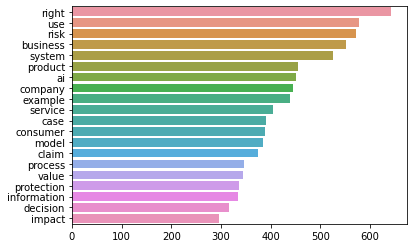

In [27]:
import seaborn as sns
import seaborn as sns

def displayEntitiesChart(commonEntities,n=20, save=False, saveToFile='test.jpg'):
    x, y= [], []
    for word,count in commonEntities[:n]:
            x.append(word)
            y.append(count)
        
    plot= sns.barplot(x=y,y=x)
    if save:
        fig = plot.get_figure()
        fig.savefig(saveToFile)
displayEntitiesChart(commonWords)



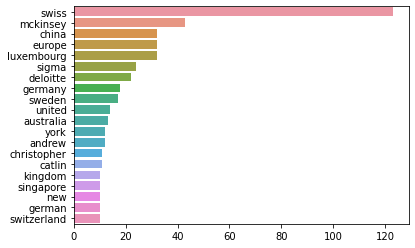

In [28]:
# get most common proper nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    
    words += [token.lemma_ for token in doc if token.pos==PROPN and (not token.lemma_ in STOP_WORDS)\
             and (len(token)>1)] 


# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
displayEntitiesChart(commonWords)

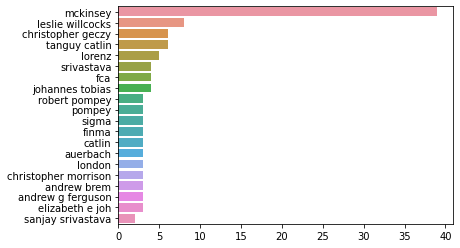

In [29]:
# most frequest PERSON entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'PERSON':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities)

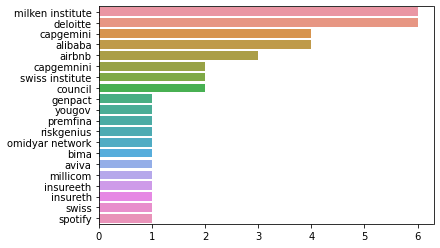

In [32]:
# most frequest ORG entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'ORG':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
displayEntitiesChart(commonEntities,20,True,'spacy30trf.jpg')